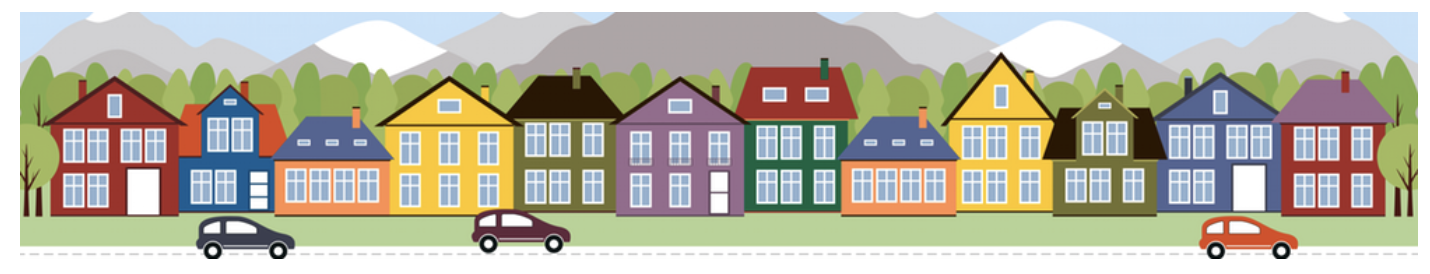

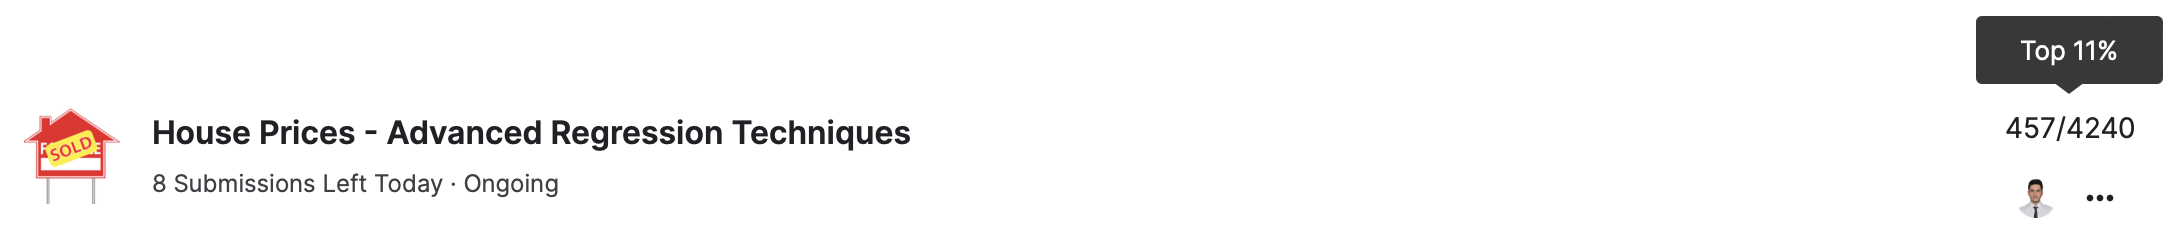

# House Prices - Advanced Regression Techniques


# Table of Contents

*  [1) Introduction](#intro)

*  [2) Getting started](#getting_started)
    *  [2.1) Libraries](#lib)
    *  [2.2) Acquire Data](#acq)
    *  [2.3) Combine Train and Test Sets](#combine)
 
*  [3) Exploratory Data analysis](#exp)

*  [4) Data Cleaning](#dc)
    *  [4.1) Categorical Missing Values](#cmv)
    *  [4.1) Numeric  Missing Values](#nmv)
    
*  [5) Feature Engineering](#fe)
*  [6) Data Preprocessing for Model](#dpm)
    *  [6.1) Split data](#sd2)
*  [7) Model Selection](#ms)
    *  [7.1) Hyperparameter Optimization](#ho)
    *  [7.2) Evaluation](#ev)
*  [8) Submission](#sub)

<a id="intro"></a>
# 1) Introduction

***This is my second machine learning work in Kaggle. I'm trying to implement my work from different sources. This notebook contains simple ml steps. I have reviewed many studies on the parts of data engineering. I hope you enjoy reviewing the notebook.***

<a id="getting_started"></a>
# 2) Getting Started

<a id="lib"></a>
### 2.1) Libraries

In [ ]:
# Data Analysis and wrangling
import numpy as np
import pandas as pd
from collections import Counter
from scipy.stats import loguniform
import scipy
pd.set_option('max_columns', None)
pd.set_option('max_rows', 90)
import warnings
warnings.filterwarnings('ignore')



# Visualization

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook',font_scale=1.8)
sns.set_style('darkgrid')

# Preprocessing for models
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import make_pipeline

# Machine Learning
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor


# Model Performance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,cross_val_score,RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold, cross_validate



<a id="acq"></a>
## 2.2) Acquire Data

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

train0 = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test0 = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

<a id="combine"></a>
## 2.3) Combine Train and Test Sets

In [ ]:
target_0 = train0['SalePrice']
Test_id = test0['Id']

train1 = train0.drop(labels=['Id','SalePrice'],axis=1)
test1 = test0.drop(labels=['Id'],axis=1)

data0 = pd.concat([train1,test1],axis=0).reset_index(drop=True)

<a id="exp"></a>
#  3) Exploratory Data Analysis

In [ ]:
def miss_df(df,ascending):
    
    Missing_count = df.isna().sum().sort_values(ascending=ascending)
    Missing_count = Missing_count[df.isna().sum().sort_values(ascending=ascending)!= 0]
    
    Percentage = (df.isna().sum().sort_values(ascending=ascending)/len(df)*100)[
        (df.isna().sum().sort_values(ascending=ascending)/len(df)*100) !=0
    ]
    
    return pd.concat([Missing_count,Percentage],axis=1,keys=['Missing_Count','Percentage'])

def miss_plot(df):
    fig,ax = plt.subplots(figsize=(20,10))
    sns.barplot(data=df,x=df.index,y='Percentage',palette='winter')
    plt.axhline(y= len(df)/4, linewidth = 1.5, color= 'red')
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
Missing_columns = miss_df(train0,False)
miss_plot(Missing_columns)

In [ ]:
Missing_columns = miss_df(test0,False)
miss_plot(Missing_columns)

In [ ]:
def dist_skew(target):
    fig, axs = plt.subplots(1,2, figsize=(18, 9))
    sns.distplot(target,kde=True,fit=scipy.stats.norm,ax=axs[0],color='darkblue')
    axs[0].set_title('Without log')
    axs[0].set_xlabel('Skew:{:.4f}'.format(scipy.stats.skew(target)))
    sns.distplot(np.log(target),kde=True,fit=scipy.stats.norm,ax=axs[1])
    axs[1].set_title('With log')
    axs[1].set_xlabel('Skew:{:.4f}'.format(scipy.stats.skew(np.log(target))))
    plt.show()
    
def box_skew(target):
    fig, axs = plt.subplots(1,2, figsize=(18, 9))
    sns.boxplot(target,ax=axs[0],color='darkblue')
    axs[0].set_title('Without log')
    axs[0].set_xlabel('Skew:{:.4f}'.format(scipy.stats.skew(target)))
    sns.boxplot(np.log(target),ax=axs[1])
    axs[1].set_title('With log')
    axs[1].set_xlabel('Skew:{:.4f}'.format(scipy.stats.skew(np.log(target))))
    plt.show()

In [ ]:
train0['SalePrice'].describe()

In [ ]:
T_target_0 = np.log(target_0)
dist_skew(target_0)

In [ ]:
box_skew(target_0)

In [ ]:
k2, p = scipy.stats.normaltest(target_0)
alpha = 1e-3
print("p = {:g}".format(p))
print("alpha = {:g}".format(alpha))
# null hypothesis: x comes from a normal distribution
if p < alpha:
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

In [ ]:
k2, p = scipy.stats.normaltest(T_target_0)
alpha = 1e-3
print("p = {:g}".format(p))
print("alpha = {:g}".format(alpha))
# null hypothesis: x comes from a normal distribution
if p < alpha:
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

In [ ]:
corrmat = train0.corr()
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, vmax=.9, square=True);

In [ ]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train0[cols], size = 2.5)
plt.show()

<a id="dc"></a>
# 4) Data Cleaning

In [ ]:
data1 = data0.copy()

In [ ]:
def outliers(df,num_columns):
    global multiple_outliers
    index_list = []
    for num_col in num_columns:
        Q1 = np.percentile(df[num_col], 25)
        Q3 = np.percentile(df[num_col],75)
        IQR = Q3 - Q1

        outlier_list = df[(df[num_col] < Q1 - 1.5 * IQR) | (df[num_col] > Q3 + 1.5 * IQR )].index
        index_list.extend(outlier_list)
        
        
        
    index_list = Counter(index_list)        
    multiple_outliers = list( i for i, j in index_list.items() if j > 1 )
    return multiple_outliers 




Outliers_to_drop = outliers(train1,train1.select_dtypes(np.number).columns)
data_outliers_dropped = train1.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
Target_1 = train0.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)['SalePrice']

In [ ]:
train2 = data_outliers_dropped
T_target_1 = np.log(Target_1)
data1 = pd.concat([train2,test1],axis=0).reset_index(drop=True)

In [ ]:
k2, p = scipy.stats.normaltest(T_target_1)
alpha = 1e-3
print("p = {:g}".format(p))
print("alpha = {:g}".format(alpha))
# null hypothesis: x comes from a normal distribution
if p < alpha:
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

In [ ]:
for column in [
    'Alley',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature'
]:
    data1[column] = data1[column].fillna("None")

for column in [
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Electrical',
    'KitchenQual',
    'Functional',
    'SaleType'
]:
    data1[column] = data1[column].fillna(data1[column].mode()[0])

In [ ]:
def knn_impute(df, na_target):
    df = df.copy()
    
    numeric_df = df.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns
    
    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target]
    X_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns]
    X_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]
    
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    df.loc[df[na_target].isna() == True, na_target] = y_pred
    
    return df

In [ ]:
cols = data1.select_dtypes(exclude='object').columns[data1.select_dtypes(exclude='object').isnull().any()].tolist()

for col in cols:
    
    data1 = knn_impute(data1,col)

<a id="fe"></a>
# 5. Feature Engineering

In [ ]:
data2 = data1.copy()

In [ ]:
SqFt = [data2.columns.get_loc(c) for c in ["GrLivArea","TotRmsAbvGrd","FullBath","HalfBath","KitchenAbvGr"]]
TB = [data2.columns.get_loc(c) for c in ['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath']]
TH = [data2.columns.get_loc(c) for c in ['OverallQual','OverallCond']]
HqSF = [data2.columns.get_loc(c) for c in ["1stFlrSF","2ndFlrSF"]]

In [ ]:
class Combine(BaseEstimator,TransformerMixin):
    
    def __init__(self,total_bath=True):
        self.total_bath = total_bath
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        
        SqFtPerRoom = X[:,SqFt[0]] / (X[:,SqFt[1]]+X[:,SqFt[2]]+X[:,SqFt[3]]+X[:,SqFt[4]])
    
        Total_Home_Quality = X[:,TH[0]] + X[:,TH[1]]
        
        HighQualSF = X[:,HqSF[0]] + X[:,HqSF[1]]
        
        if self.total_bath == True:
            
            Total_Bathrooms = X[:,TB[0]] + 0.5*X[:,TB[1]] + X[:,TB[2]] + 0.5*X[:,TB[3]]
            return np.c_[X,SqFtPerRoom,Total_Home_Quality,HighQualSF,Total_Bathrooms]
        
        else:
            return np.c_[X,SqFtPerRoom,Total_Home_Quality,HighQualSF]
        
Combiner = Combine(total_bath=True)
data2 = Combiner.transform(data2.values)

In [ ]:
col_T = ['SqFtPerRoom','Total_Home_Quality','HighQualSF','Total_Bathrooms']
data2 = pd.DataFrame(
    data2,
    columns=list(data1.columns)+col_T,
    index=data1.index)
data2.head()

<a id="dpm"></a>
# 6) Data Preprocessing for Models

In [ ]:
num_attribs = list(data1.select_dtypes(exclude=['object']).columns)
num_attribs.extend(col_T)
cat_attribs = data1.select_dtypes(include=['object']).columns

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

data2_prepared = full_pipeline.fit_transform(data2)

In [ ]:
data2_prepared = pd.DataFrame(data2_prepared.toarray())

<a id="sd2"></a>
## 6.1) Split data

In [ ]:
train_final = data2_prepared.loc[:train2.index.max(), :].copy()
test_final = data2_prepared.loc[train2.index.max() + 1:, :].reset_index(drop=True).copy()

In [ ]:
test_final.shape

In [ ]:
train_final.shape

In [ ]:
T_target_1.shape

<a id="ms"></a>
# 7) Model Selection

In [ ]:
models = { 'gbc': GradientBoostingRegressor(),
          'xgb':XGBRegressor(),
          'rfr':RandomForestRegressor(),
          'lgb':LGBMRegressor()
    }

In [ ]:
for name, model in models.items():
    model.fit(train_final,T_target_1)
    print(name+ 'trained')

In [ ]:
results = {}

kf = KFold(n_splits=10)

for name, model in models.items():
    result = np.exp(np.sqrt(-cross_val_score(model, train_final, T_target_1, scoring='neg_mean_squared_error', cv=kf)))
    results[name] = result

In [ ]:
for name, result in results.items():
    print(name + '\n---------')
    print(np.mean(result))
    print(np.std(result))

In [ ]:
df = pd.DataFrame(results)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7))

sns.histplot(data=df, x="gbc", kde=True, color="skyblue", ax=axs[0, 0],bins=6)
sns.histplot(data=df, x="xgb", kde=True, color="olive", ax=axs[0, 1],bins=6)
sns.histplot(data=df, x="rfr", kde=True, color="gold", ax=axs[1, 0],bins=6)
sns.histplot(data=df, x="lgb", kde=True, color="teal", ax=axs[1, 1],bins=6)
plt.show()

## 7.1) Hyperparameter Optimization

In [ ]:
param_distributions = {
    "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100,200],
    "learning_rate": loguniform(0.01, 1),
}

In [ ]:
search_cv = RandomizedSearchCV(
    GradientBoostingRegressor(), param_distributions=param_distributions,
    scoring="neg_mean_absolute_error", n_iter=20, random_state=0, n_jobs=2
)

In [ ]:
search_cv.fit(train_final, T_target_1)

In [ ]:
columns = [f"param_{name}" for name in param_distributions.keys()]
columns += ["mean_test_error", "std_test_error"]
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results["mean_test_error"] = np.exp(-cv_results["mean_test_score"])
cv_results["std_test_error"] = np.exp(cv_results["std_test_score"])
cv_results[columns].sort_values(by="mean_test_error")

<a id="sub"></a>
# 8) Submission

In [ ]:
test_final.shape

In [ ]:
test0.shape

In [ ]:
final_pred = np.exp(search_cv.predict(test_final))
submission = pd.concat([Test_id,pd.Series(final_pred,name="SalePrice")],axis=1)
submission.to_csv("./submission.csv",index=False,header=True)
submission

## Thank you for checking my notebook, I will be glad to share your thoughts.